# Simple 3D Finite Plasticity model



In [1]:
import numpy as np

import dolfinx

from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import fem, mesh, io, plot, log,default_scalar_type
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem,LinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import XDMFFile
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional , gt, dx, inner, derivative, dot, ln, split,TestFunction,indices,as_tensor)
from basix.ufl import element, mixed_element, quadrature_element
from datetime import datetime
from dolfinx.plot import vtk_mesh
from dolfinx.fem.petsc import  assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc,create_matrix, create_vector
import basix
import pyvista
pyvista.set_jupyter_backend('client')
## Define temporal parameters

## Some parameters

In [2]:
# Geometric parameters
geom = {"longside" : 100.0,     # mm
        "side" : 10.0,      # mm
        "num_elements" : 3,    # size of a cell
        }


# Mechanicals parameters
mech = {"E" : 200e3,    # MPa
        "nu" : 0.3,     #       
        "sig0" : 100.,  # MPa
        "H" : 80e3, # MPa
        "r" : 1.0,
        "Y_s" : 250.0 #mpa
        
        }


# Study parameters
stud = {"deg u" : 2,    # Interpolation of u
        "deg sig" : 2,  # Interpolation of sig, eps, p
        "N incr" : 100,  # Number of load steps
        "Max Disp" : 1 # Maximal displacement
        }


# Define Geometry

In [3]:

domain = mesh.create_box(MPI.COMM_WORLD,[[0.0,0.0,0.0],[geom["longside"],geom["side"],geom["side"]]],[geom["num_elements"]*10,geom["num_elements"],geom["num_elements"]])

In [4]:
plotter = pyvista.Plotter()
vtkdata = vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(*vtkdata)
actor = plotter.add_mesh(grid, show_edges=True)
plotter.show()
plotter.close()

Widget(value="<iframe src='http://localhost:45615/index.html?ui=P_0xffff6c1574c0_0&reconnect=auto' style='widt…

## Material Parameters

In [5]:
E = Constant(domain, mech["E"])
nu = Constant(domain, mech["nu"])
lmbda = E * nu / (1 + nu) / (1 - 2 * nu)
mu = E / 2.0 / (1 + nu)
sig0 = Constant(domain, mech["sig0"])  # yield strength
H_0 = Constant(domain,mech["H"])  # hardening modulus
r = Constant(domain,mech["r"])  # hardening modulus
Y_s = Constant(domain,mech["Y_s"])  # hardening modulus

## Defining Boundary

In [6]:
def xBot(x):
    return np.isclose(x[0], 0)
def xTop(x):
    return np.isclose(x[0], geom["longside"])
def yBot(x):
    return np.isclose(x[1], 0)
def yTop(x):
    return np.isclose(x[1], geom["side"])
def zBot(x):
    return np.isclose(x[2], 0)
def zTop(x):
    return np.isclose(x[2], geom["side"])

In [7]:
boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop),(5,zBot),(6,zTop)]

facet_indices, facet_markers = [], []
fdim = domain.topology.dim - 1
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))

facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])


# Defining Function Spaces

In [8]:
deg_u = stud["deg u"]
deg_stress = stud["deg sig"]
Ve = element(
    "Lagrange", domain.basix_cell(), deg_u, shape=(3,)
)  # 2 degrees  of freedom
V = functionspace(domain, Ve)

Ve_scal = element(
    "Lagrange", domain.basix_cell(), deg_u
)
V_scal = functionspace(domain, Ve_scal)

We = quadrature_element(domain.basix_cell(), value_shape=(6,), degree=deg_stress,scheme='default')
W = functionspace(domain, We)

W_scal_e = quadrature_element(domain.basix_cell(), degree=deg_stress,scheme='default')
W_scal = functionspace(domain, W_scal_e)

In [9]:
T = Function(W,name = "Stress")
E_p = Function(W, name="Total_Plastic_Strain")
e_p= Function(W_scal, name="Equivalent_Plastic_Strain")
u = Function(V, name="Total_displacement")
du = Function(V, name="Trial_displacement")

dp = Function(W_scal,name="Delta_plasticity")

Y = Function(W_scal,name="Isotropic Hardening")
A = Function(W_scal,name="Kinematic Hardening")

Y.interpolate(lambda x: np.full_like(x[0],mech["sig0"]))


v = TestFunction(V) #Function we are testing with
du_ = TrialFunction(V) #Function we are solving for

e_p_ = TrialFunction(W_scal)
e_pv = TestFunction(W_scal)


dx = ufl.Measure("dx",domain=domain,  metadata={"quadrature_degree": deg_u, "quadrature_scheme": "default"} )
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tag,metadata={'quadrature_degree': deg_u})

n = ufl.FacetNormal(domain)

# Boundary Conditions

In [10]:
left_facets = facet_tag.find(1)
right_facets = facet_tag.find(2)
fdim = domain.topology.dim - 1
domain.topology.create_connectivity(fdim, domain.topology.dim)
disp = Constant(domain,0.0)

left_dofs_x = fem.locate_dofs_topological(V, fdim, left_facets)
right_dofs_x = fem.locate_dofs_topological(V.sub(0),fdim, right_facets)

sym_bottom = fem.dirichletbc(np.array((0.0,0.0,0.0)), left_dofs_x, V)
sym_left = fem.dirichletbc(disp, right_dofs_x, V.sub(0))

bcs = [sym_bottom, sym_left]



def F_ext(t):
    return t*stud["Max Disp"]

# Constitive Relations

In [11]:
from ufl.tensors import ComponentTensor


def eps(v: Function) -> ComponentTensor:
    """
    Generates a  strain tensor from input of a 3D displacement vector.


    Parameters:
    -----------
        u (2d Vector Funciton): 3D displacement vector.

    Returns:
    --------
        3x3 Tensor: Plain strain tensor generated from the displacement vector.
    """
    e = ufl.sym(grad(v))
    return e # Plain strain tensor


def sigma_tr(eps_el):
    """
    Generates the stress tensor from the input of a plain strain tensor.

    Parameters:
    ----------
        eps_el (numpy.ndarray): Plain strain tensor.

    Returns:
    --------
        3x3 Tensor: the trace of the plain stress tensor
    """
    return 1./3. * (3. * lmbda + 2. * mu) * ufl.tr(eps_el) * ufl.Identity(3)


def sigma_dev(eps_el):
    """
    Generates the stress tensor from the input of a plain strain tensor.

    Parameters:
    ----------
        eps_el (numpy.ndarray): Plain strain tensor.

    Returns:
    --------
        3x3 Tensor: The deviatoric part of the stress tensor.
    """
    return 2. * mu * ufl.dev(eps_el)


def as_3D_tensor(X):
    """Converts an array to a 3D tensor.

    Parameters:
    ----------
       X (Function): Array to be converted to 3D tensor.

    Returns:
    --------
        3x3 Tensor: 3D tensor generated from the input array.
    """
    return ufl.as_tensor([[X[0], X[3], X[4]],
                      [X[3], X[1], X[5]],
                      [X[4], X[5], X[2]]])

def tensor_to_vector(X): 
    ''' 
    Take a 3x3 tensor and return a vector of size 4 in 2D
    '''
    return ufl.as_vector([X[0, 0], X[1, 1], X[2, 2], X[0, 1], X[0, 2], X[1, 2]])


def sigma(eps_el: Function) -> ComponentTensor:
    
    return lmbda * tr(eps_el) * Identity(3) + 2 * mu * eps_el


In [12]:
def normVM(sig): # Von Mises equivalent stress
    s_ = ufl.dev(sig)
    return ufl.sqrt(3 / 2. * ufl.inner(s_, s_))

In [13]:
#This is the plastic stress function (For now we'll just assume regular strain hardening)


def Y_dot(e_p):
    
    H_val = H_0*(1-Y/Y_s)**r
    return H_val * e_p

In [14]:
E_n = eps(u)
del_E_n = eps(du_)
E_p_tensor = as_3D_tensor(E_p)
E_e_trial = E_n - E_p_tensor + del_E_n #Trial Elastic Strain

T_trial = sigma(E_e_trial) #Trial cauchy stress
#bilinear Part to solve for du Incrementally
#This is the linear part (In total this will be 0)
F_body = Constant(domain,np.array((0.0,0.0,0.0)))

F = ufl.inner(T_trial,eps(v))*dx - ufl.inner(F_body, v) * dx 

a_du, L_du = ufl.lhs(F), ufl.rhs(F)

In [15]:

del_E = eps(du)
E_e_trial_plastic = E_n - E_p_tensor + del_E #Trial Elastic Strain for plastic step
T_trial_p = sigma(E_e_trial_plastic)

sigma_vm_trial = normVM(T_trial_p) #Trial Von Mises Stress

N_p = dev(T_trial_p)/sigma_vm_trial

f_trial = sigma_vm_trial - Y #Trial Yield Function


Phi = sigma_vm_trial - 3*mu*dp - Y - Y_dot(dp)
Phi_cond = conditional(gt(f_trial, 0) , Phi, dp) #Plastic multiplier

res_p = inner(Phi_cond,e_pv)*dx


Jacobian = derivative(res_p,dp,e_p_)

In [16]:

problem = NonlinearProblem(res_p, dp, [], Jacobian)
nls_solver = NewtonSolver(MPI.COMM_WORLD, problem)
nls_solver.convergence_criterion = "incremental"
nls_solver.rtol = 1e-8
nls_solver.atol = 1e-8
nls_solver.max_it = 50
nls_solver.report = True
nls_solver.relaxation_parameter = 1



ksp = nls_solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
#opts[f"{option_prefix}pc_hypre_type"] = "boomeramg"
#opts[f"{option_prefix}pc_factor_mat_solver_type"] = "superlu_dist"
opts[f"{option_prefix}ksp_max_it"] = 50
ksp.setFromOptions()

In [17]:
def project(v, target_func, bcs=[]):
    """Project UFL expression.

    Note
    ----
    This method solves a linear system (using KSP defaults).

    """

    # Ensure we have a mesh and attach to measure
    V = target_func.function_space
    dx = ufl.dx(V.mesh)

    # Define variational problem for projection
    w = ufl.TestFunction(V)
    Pv = ufl.TrialFunction(V)
    a = dolfinx.fem.form(ufl.inner(Pv, w) * dx)
    L = dolfinx.fem.form(ufl.inner(v, w) * dx)

    # Assemble linear system
    A = assemble_matrix(a, bcs)
    A.assemble()
    b = assemble_vector(L)
    apply_lifting(b, [a], [bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, bcs)

    # Solve linear system
    solver = PETSc.KSP().create(A.getComm())
    solver.setOperators(A)
    solver.solve(b, target_func.vector)

    # Destroy PETSc linear algebra objects and solver
    solver.destroy()
    A.destroy()
    b.destroy()

In [18]:
def solve_plastic():
    # Solve DP

    nls_solver.solve(dp)
    # Do updates
    e_p_exp = Expression(e_p+dp,W_scal.element.interpolation_points())
    e_p.interpolate(e_p_exp)
    
    E_p_expr = Expression(E_p+tensor_to_vector(N_p*dp*sqrt(3/2)),W.element.interpolation_points())
    
    E_p.interpolate(E_p_expr)
    
    Y_exp = Expression(Y + Y_dot(dp),W_scal.element.interpolation_points())
    Y.interpolate(Y_exp)

In [19]:
def interpolate_quadrature(ufl_expr, fem_func:fem.Function):
    q_dim = fem_func.function_space._ufl_element.degree
    mesh = fem_func.ufl_function_space().mesh
    
    basix_celltype = mesh.basix_cell()
    quadrature_points, weights = basix.make_quadrature(basix_celltype, q_dim)
    map_c = mesh.topology.index_map(mesh.topology.dim)
    num_cells = map_c.size_local + map_c.num_ghosts
    cells = np.arange(0, num_cells, dtype=np.int32)

    expr_expr = fem.Expression(ufl_expr, quadrature_points)
    expr_eval = expr_expr.eval(mesh,cells)
    fem_func.x.array[:] = expr_eval.flatten()

In [20]:

a = fem.form(a_du)
L = fem.form(L_du)
A = assemble_matrix(a, bcs=bcs)
A.assemble()
b = create_vector(L)
assemble_vector(b, L)
apply_lifting(b, [a], [bcs],[u.vector], scale=1)
set_bc(b, bcs,u.vector)


Stress_Point = sigma(E_n - E_p_tensor)
area= Constant(domain,(geom["side"]*geom["side"]))

Elastic = Function(V_scal)
project(Stress_Point[0,0],Elastic)
engineeringStress= fem.form(Elastic/area*ds(2)) #P22/area*ds

In [21]:
pointForStress = [geom["longside"],0,0]

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, np.array(pointForStress))
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates,  np.array(pointForStress))

In [22]:
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

def solve_linear():
    with b.localForm() as loc_L:
            loc_L.set(0)
    A.zeroEntries()
    assemble_matrix(A,a, bcs=bcs)
    A.assemble()
    assemble_vector(b, L)
    
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    apply_lifting(b, [a], [bcs],[ u.vector], scale=1)

    set_bc(b, bcs,u.vector)
    
    res2val = solver.solve(b, du.vector)



In [23]:
du.x.array

array([0., 0., 0., ..., 0., 0., 0.])

In [24]:
tes= Function(W_scal)
tes_exp = Expression(Phi,W_scal.element.interpolation_points())
tes.interpolate(tes_exp)
tes.x.array

array([-100., -100., -100., ..., -100., -100., -100.])

In [25]:
startTime = datetime.now()
Nincr = stud["N incr"]

load_steps = np.linspace(0, .2, Nincr+1)[1:]
results = np.zeros((Nincr+1, 2))


print("------------------------------------")
print("Simulation Start")
print("------------------------------------")


log.set_log_level(log.LogLevel.INFO)

for (i, t) in enumerate(load_steps):
    # Update Diriclet boundary condition
    du.x.array[:] = 0.0
    dp.x.array[:] = 0.0
    disp.value = F_ext(t)
    # Update the right hand side reusing the initial vector

    nRes0 = b.norm()
    nRes = nRes0
    print("Increment:", str(i+1))
    niter = 0
    print("Linear Step 1 Start")
    solve_linear() #Solves for the first trial displacement
    print("Linear Step 1 Done")
    print("Starting Plastic Step")
    solve_plastic()
    print("Stop Plastic Step  Done")
    print("Linear Step 2 Start")
    solve_linear() #Solves for the actual displacement after the plastic update
    print("Linear Step 1 Done")
    
    
    u.x.array[:] += du.x.array[:]
    
    
    project(Stress_Point[0,0],Elastic)
    u_pointe = u.eval(pointForStress,colliding_cells.array[0])[0]
    stress =  domain.comm.gather(fem.assemble_scalar(engineeringStress))[0]
    results[i + 1, :] = (u_pointe,stress)
    

print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")    
    

------------------------------------
Simulation Start
------------------------------------
Increment: 1
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 17:25:19.182 (   2.362s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:19.184 (   2.364s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:19.185 (   2.365s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:19.185 (   2.365s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 2
Linear Step 1 Start


2023-12-09 17:25:19.409 (   2.590s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:19.630 (   2.811s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:19.632 (   2.812s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:19.633 (   2.813s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:19.633 (   2.813s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 3
Linear Step 1 Start


2023-12-09 17:25:19.853 (   3.034s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:20.068 (   3.248s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:20.069 (   3.250s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:20.070 (   3.251s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:20.070 (   3.251s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 4
Linear Step 1 Start


2023-12-09 17:25:20.289 (   3.470s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:20.511 (   3.692s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:20.513 (   3.693s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:20.514 (   3.694s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:20.514 (   3.694s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 5
Linear Step 1 Start


2023-12-09 17:25:20.738 (   3.919s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 17:25:20.958 (   4.138s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:20.960 (   4.140s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:20.960 (   4.141s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:20.960 (   4.141s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 6
Linear Step 1 Start


2023-12-09 17:25:21.177 (   4.357s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:21.389 (   4.570s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:21.391 (   4.571s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:21.392 (   4.572s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:21.392 (   4.572s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 7
Linear Step 1 Start


2023-12-09 17:25:21.610 (   4.791s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:21.829 (   5.009s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:21.830 (   5.010s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:21.831 (   5.011s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:21.831 (   5.011s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 8
Linear Step 1 Start


2023-12-09 17:25:22.049 (   5.229s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:22.263 (   5.443s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:22.265 (   5.445s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:22.265 (   5.446s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:22.265 (   5.446s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 9
Linear Step 1 Start


2023-12-09 17:25:22.480 (   5.660s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:22.693 (   5.873s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:22.694 (   5.875s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:22.695 (   5.875s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:22.695 (   5.875s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 10
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 17:25:22.909 (   6.090s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:23.121 (   6.302s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:23.123 (   6.303s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:23.123 (   6.304s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:23.123 (   6.304s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 11
Linear Step 1 Start


2023-12-09 17:25:23.339 (   6.520s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:23.559 (   6.739s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:23.560 (   6.740s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:23.561 (   6.741s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:23.561 (   6.741s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 12
Linear Step 1 Start


2023-12-09 17:25:23.774 (   6.955s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:23.987 (   7.167s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:23.988 (   7.169s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:23.989 (   7.169s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:23.989 (   7.169s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 13
Linear Step 1 Start


2023-12-09 17:25:24.204 (   7.385s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:24.417 (   7.598s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:24.419 (   7.599s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:24.419 (   7.600s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:24.419 (   7.600s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 14
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 17:25:24.635 (   7.816s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:24.855 (   8.036s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:24.857 (   8.037s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:24.858 (   8.038s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:24.858 (   8.038s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 15
Linear Step 1 Start


2023-12-09 17:25:25.079 (   8.260s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:25.297 (   8.478s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:25.299 (   8.479s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:25.300 (   8.480s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:25.300 (   8.480s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done


2023-12-09 17:25:25.527 (   8.707s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:25.751 (   8.931s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:25.752 (   8.933s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:25.753 (   8.934s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:25.753 (   8.934s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Increment: 16
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 17
Linear Step 1 Start


2023-12-09 17:25:25.981 (   9.161s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:26.202 (   9.383s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:26.204 (   9.384s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:26.205 (   9.385s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:26.205 (   9.385s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 18
Linear Step 1 Start


2023-12-09 17:25:26.432 (   9.613s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:26.651 (   9.832s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:26.653 (   9.833s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:26.654 (   9.834s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:26.654 (   9.834s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 19
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 17:25:26.876 (  10.057s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:27.098 (  10.278s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:27.100 (  10.280s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:27.100 (  10.281s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:27.100 (  10.281s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 20
Linear Step 1 Start


2023-12-09 17:25:27.326 (  10.507s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:27.547 (  10.727s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:27.548 (  10.729s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:27.549 (  10.730s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:27.549 (  10.730s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 21
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 17:25:27.780 (  10.960s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:28.002 (  11.183s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:28.004 (  11.184s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:28.005 (  11.185s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:28.005 (  11.185s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 22
Linear Step 1 Start


2023-12-09 17:25:28.227 (  11.408s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:28.447 (  11.628s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:28.449 (  11.629s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:28.450 (  11.630s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 17:25:28.450 (  11.630s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 23
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 17:25:28.671 (  11.851s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:28.890 (  12.070s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:28.891 (  12.072s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:28.892 (  12.072s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.72837e-20 (tol = 1e-08) r (rel) = 1.97026e-15(tol = 1e-08)
2023-12-09 17:25:28.892 (  12.072s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 24
Linear Step 1 Start


2023-12-09 17:25:29.107 (  12.287s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:29.328 (  12.509s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:29.330 (  12.510s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:29.331 (  12.511s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 3.40966e-20 (tol = 1e-08) r (rel) = 9.71011e-16(tol = 1e-08)
2023-12-09 17:25:29.331 (  12.511s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 25
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 17:25:29.556 (  12.737s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:29.773 (  12.953s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:29.774 (  12.955s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:29.775 (  12.956s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.15595e-18 (tol = 1e-08) r (rel) = 7.72136e-15(tol = 1e-08)
2023-12-09 17:25:29.775 (  12.956s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 26
Linear Step 1 Start


2023-12-09 17:25:29.988 (  13.169s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:30.202 (  13.383s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:30.204 (  13.384s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:30.205 (  13.385s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.1827e-18 (tol = 1e-08) r (rel) = 1.01677e-15(tol = 1e-08)
2023-12-09 17:25:30.205 (  13.385s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 27
Linear Step 1 Start


2023-12-09 17:25:30.420 (  13.600s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:30.633 (  13.814s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:30.635 (  13.815s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:30.636 (  13.816s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.18684e-18 (tol = 1e-08) r (rel) = 8.23614e-16(tol = 1e-08)
2023-12-09 17:25:30.636 (  13.816s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 28
Linear Step 1 Start


2023-12-09 17:25:30.849 (  14.030s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:31.063 (  14.243s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:31.064 (  14.245s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:31.065 (  14.246s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.18748e-18 (tol = 1e-08) r (rel) = 7.84471e-16(tol = 1e-08)
2023-12-09 17:25:31.065 (  14.246s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 29
Linear Step 1 Start


2023-12-09 17:25:31.283 (  14.463s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:31.496 (  14.676s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:31.498 (  14.678s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:31.498 (  14.679s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.2075e-18 (tol = 1e-08) r (rel) = 7.87434e-16(tol = 1e-08)
2023-12-09 17:25:31.498 (  14.679s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 30
Linear Step 1 Start


2023-12-09 17:25:31.712 (  14.893s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:31.930 (  15.111s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:31.932 (  15.113s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:31.933 (  15.113s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.20684e-18 (tol = 1e-08) r (rel) = 7.83877e-16(tol = 1e-08)
2023-12-09 17:25:31.933 (  15.113s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 31
Linear Step 1 Start


2023-12-09 17:25:32.155 (  15.335s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 17:25:32.371 (  15.552s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:32.373 (  15.553s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:32.374 (  15.554s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.19715e-18 (tol = 1e-08) r (rel) = 7.76227e-16(tol = 1e-08)
2023-12-09 17:25:32.374 (  15.554s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 32
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 17:25:32.588 (  15.769s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:32.800 (  15.981s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:32.802 (  15.982s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:32.803 (  15.983s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.20386e-18 (tol = 1e-08) r (rel) = 7.7957e-16(tol = 1e-08)
2023-12-09 17:25:32.803 (  15.983s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 33
Linear Step 1 Start


2023-12-09 17:25:33.021 (  16.201s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:33.234 (  16.414s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:33.235 (  16.416s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:33.236 (  16.417s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.20131e-18 (tol = 1e-08) r (rel) = 7.77016e-16(tol = 1e-08)
2023-12-09 17:25:33.236 (  16.417s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 34
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 17:25:33.451 (  16.632s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:33.664 (  16.844s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:33.665 (  16.846s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:33.666 (  16.846s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.20402e-18 (tol = 1e-08) r (rel) = 7.77825e-16(tol = 1e-08)
2023-12-09 17:25:33.666 (  16.846s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 35
Linear Step 1 Start


2023-12-09 17:25:33.880 (  17.061s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:34.095 (  17.276s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:34.097 (  17.278s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:34.098 (  17.278s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.21701e-18 (tol = 1e-08) r (rel) = 7.85259e-16(tol = 1e-08)
2023-12-09 17:25:34.098 (  17.278s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 36
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 17:25:34.318 (  17.499s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:34.532 (  17.712s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:34.533 (  17.714s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:34.534 (  17.715s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.21034e-18 (tol = 1e-08) r (rel) = 7.79997e-16(tol = 1e-08)
2023-12-09 17:25:34.534 (  17.715s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 37
Linear Step 1 Start


2023-12-09 17:25:34.751 (  17.931s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:34.964 (  18.144s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:34.966 (  18.146s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:34.967 (  18.147s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.20544e-18 (tol = 1e-08) r (rel) = 7.75881e-16(tol = 1e-08)
2023-12-09 17:25:34.967 (  18.147s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 38
Linear Step 1 Start


2023-12-09 17:25:35.185 (  18.365s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:35.400 (  18.581s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:35.402 (  18.583s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:35.403 (  18.583s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.21321e-18 (tol = 1e-08) r (rel) = 7.799e-16(tol = 1e-08)
2023-12-09 17:25:35.403 (  18.583s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 39
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 17:25:35.618 (  18.799s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:35.832 (  19.012s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:35.833 (  19.014s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:35.834 (  19.014s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.21706e-18 (tol = 1e-08) r (rel) = 7.81371e-16(tol = 1e-08)
2023-12-09 17:25:35.834 (  19.014s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 40
Linear Step 1 Start


2023-12-09 17:25:36.047 (  19.228s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:36.260 (  19.440s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:36.261 (  19.442s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:36.262 (  19.442s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.2163e-18 (tol = 1e-08) r (rel) = 7.79906e-16(tol = 1e-08)
2023-12-09 17:25:36.262 (  19.442s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 41
Linear Step 1 Start


2023-12-09 17:25:36.480 (  19.661s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 17:25:36.772 (  19.952s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:36.864 (  20.044s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:36.865 (  20.046s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.21327e-18 (tol = 1e-08) r (rel) = 7.76951e-16(tol = 1e-08)
2023-12-09 17:25:36.865 (  20.046s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 42
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 17:25:37.109 (  20.290s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:37.336 (  20.516s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:37.338 (  20.518s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:37.338 (  20.519s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.2375e-18 (tol = 1e-08) r (rel) = 7.91482e-16(tol = 1e-08)
2023-12-09 17:25:37.338 (  20.519s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 43
Linear Step 1 Start


2023-12-09 17:25:37.566 (  20.746s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:37.856 (  21.036s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:37.859 (  21.039s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:37.860 (  21.040s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.22226e-18 (tol = 1e-08) r (rel) = 7.80743e-16(tol = 1e-08)
2023-12-09 17:25:37.860 (  21.040s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 44
Linear Step 1 Start


2023-12-09 17:25:38.113 (  21.294s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:38.331 (  21.511s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:38.333 (  21.513s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:38.333 (  21.514s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.22663e-18 (tol = 1e-08) r (rel) = 7.8257e-16(tol = 1e-08)
2023-12-09 17:25:38.333 (  21.514s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done


2023-12-09 17:25:38.610 (  21.791s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:38.840 (  22.020s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:38.841 (  22.022s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:38.842 (  22.023s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.22388e-18 (tol = 1e-08) r (rel) = 7.79842e-16(tol = 1e-08)
2023-12-09 17:25:38.842 (  22.023s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Increment: 45
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 46
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 17:25:39.064 (  22.245s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:39.287 (  22.468s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:39.289 (  22.469s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:39.289 (  22.470s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.2309e-18 (tol = 1e-08) r (rel) = 7.8331e-16(tol = 1e-08)
2023-12-09 17:25:39.289 (  22.470s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 47
Linear Step 1 Start


2023-12-09 17:25:39.526 (  22.707s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:39.756 (  22.936s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:39.757 (  22.938s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:39.758 (  22.938s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.22365e-18 (tol = 1e-08) r (rel) = 7.77732e-16(tol = 1e-08)
2023-12-09 17:25:39.758 (  22.938s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 48
Linear Step 1 Start


2023-12-09 17:25:39.987 (  23.167s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:40.209 (  23.389s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:40.210 (  23.391s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:40.211 (  23.392s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.21871e-18 (tol = 1e-08) r (rel) = 7.73624e-16(tol = 1e-08)
2023-12-09 17:25:40.211 (  23.392s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 49
Linear Step 1 Start


2023-12-09 17:25:40.427 (  23.607s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 17:25:40.659 (  23.840s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:40.661 (  23.842s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:40.662 (  23.843s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.2298e-18 (tol = 1e-08) r (rel) = 7.79674e-16(tol = 1e-08)
2023-12-09 17:25:40.662 (  23.843s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 50
Linear Step 1 Start


2023-12-09 17:25:40.891 (  24.071s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:41.122 (  24.303s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:41.124 (  24.304s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:41.125 (  24.305s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.22739e-18 (tol = 1e-08) r (rel) = 7.77172e-16(tol = 1e-08)
2023-12-09 17:25:41.125 (  24.305s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 51
Linear Step 1 Start


2023-12-09 17:25:41.360 (  24.541s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:41.584 (  24.765s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:41.586 (  24.766s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:41.586 (  24.767s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.22796e-18 (tol = 1e-08) r (rel) = 7.76574e-16(tol = 1e-08)
2023-12-09 17:25:41.586 (  24.767s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 52
Linear Step 1 Start


2023-12-09 17:25:41.816 (  24.997s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:42.037 (  25.217s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:42.038 (  25.219s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:42.039 (  25.220s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.23706e-18 (tol = 1e-08) r (rel) = 7.81388e-16(tol = 1e-08)
2023-12-09 17:25:42.039 (  25.220s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 53
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 17:25:42.266 (  25.446s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:42.485 (  25.665s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:42.486 (  25.667s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:42.487 (  25.668s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.23247e-18 (tol = 1e-08) r (rel) = 7.77536e-16(tol = 1e-08)
2023-12-09 17:25:42.487 (  25.668s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 54
Linear Step 1 Start


2023-12-09 17:25:42.739 (  25.920s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:42.982 (  26.163s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:42.984 (  26.164s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:42.984 (  26.165s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.2443e-18 (tol = 1e-08) r (rel) = 7.84026e-16(tol = 1e-08)
2023-12-09 17:25:42.984 (  26.165s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 55
Linear Step 1 Start


2023-12-09 17:25:43.205 (  26.386s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:43.438 (  26.619s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:43.440 (  26.621s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:43.441 (  26.622s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.25521e-18 (tol = 1e-08) r (rel) = 7.89923e-16(tol = 1e-08)
2023-12-09 17:25:43.441 (  26.622s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 56
Linear Step 1 Start


2023-12-09 17:25:43.668 (  26.849s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:43.888 (  27.068s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:43.890 (  27.070s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:43.891 (  27.071s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.27916e-18 (tol = 1e-08) r (rel) = 8.03989e-16(tol = 1e-08)
2023-12-09 17:25:43.891 (  27.071s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 57
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 17:25:44.115 (  27.295s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:44.333 (  27.514s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:44.335 (  27.516s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:44.336 (  27.517s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.28256e-18 (tol = 1e-08) r (rel) = 8.05124e-16(tol = 1e-08)
2023-12-09 17:25:44.336 (  27.517s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 58
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 17:25:44.554 (  27.734s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:44.780 (  27.960s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:44.781 (  27.962s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:44.782 (  27.963s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.15925e-18 (tol = 1e-08) r (rel) = 1.35381e-15(tol = 1e-08)
2023-12-09 17:25:44.782 (  27.963s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 59
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 17:25:45.028 (  28.208s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:45.262 (  28.443s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:45.264 (  28.445s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:45.265 (  28.445s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.40189e-18 (tol = 1e-08) r (rel) = 1.50408e-15(tol = 1e-08)
2023-12-09 17:25:45.265 (  28.445s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 60
Linear Step 1 Start


2023-12-09 17:25:45.492 (  28.672s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:45.715 (  28.895s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:45.717 (  28.898s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:45.718 (  28.899s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.40234e-18 (tol = 1e-08) r (rel) = 1.50254e-15(tol = 1e-08)
2023-12-09 17:25:45.718 (  28.899s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 61
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 17:25:45.961 (  29.141s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:46.193 (  29.374s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:46.195 (  29.376s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:46.196 (  29.376s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.41086e-18 (tol = 1e-08) r (rel) = 1.50605e-15(tol = 1e-08)
2023-12-09 17:25:46.196 (  29.376s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 62
Linear Step 1 Start


2023-12-09 17:25:46.418 (  29.599s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:46.645 (  29.825s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:46.646 (  29.827s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:46.647 (  29.827s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.41696e-18 (tol = 1e-08) r (rel) = 1.50804e-15(tol = 1e-08)
2023-12-09 17:25:46.647 (  29.828s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 63
Linear Step 1 Start


2023-12-09 17:25:46.869 (  30.049s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 17:25:47.092 (  30.272s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:47.093 (  30.274s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:47.094 (  30.275s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.40697e-18 (tol = 1e-08) r (rel) = 1.5e-15(tol = 1e-08)
2023-12-09 17:25:47.094 (  30.275s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 64
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 17:25:47.324 (  30.505s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:47.562 (  30.743s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:47.564 (  30.745s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:47.565 (  30.745s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.402e-18 (tol = 1e-08) r (rel) = 1.49511e-15(tol = 1e-08)
2023-12-09 17:25:47.565 (  30.745s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 65
Linear Step 1 Start


2023-12-09 17:25:47.804 (  30.985s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:48.033 (  31.214s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:48.035 (  31.216s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:48.037 (  31.217s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.44098e-18 (tol = 1e-08) r (rel) = 1.51757e-15(tol = 1e-08)
2023-12-09 17:25:48.037 (  31.217s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 66
Linear Step 1 Start


2023-12-09 17:25:48.268 (  31.448s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:48.495 (  31.676s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:48.497 (  31.678s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:48.499 (  31.679s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.43499e-18 (tol = 1e-08) r (rel) = 1.51206e-15(tol = 1e-08)
2023-12-09 17:25:48.499 (  31.679s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 67
Linear Step 1 Start


2023-12-09 17:25:48.725 (  31.906s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:48.950 (  32.130s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:48.951 (  32.132s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:48.952 (  32.133s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.47138e-18 (tol = 1e-08) r (rel) = 1.53283e-15(tol = 1e-08)
2023-12-09 17:25:48.952 (  32.133s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 68
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 17:25:49.176 (  32.357s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:49.395 (  32.575s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:49.397 (  32.577s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:49.397 (  32.578s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.45023e-18 (tol = 1e-08) r (rel) = 1.51791e-15(tol = 1e-08)
2023-12-09 17:25:49.397 (  32.578s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 69
Linear Step 1 Start


2023-12-09 17:25:49.619 (  32.800s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:49.841 (  33.022s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:49.843 (  33.023s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:49.844 (  33.024s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.44659e-18 (tol = 1e-08) r (rel) = 1.51387e-15(tol = 1e-08)
2023-12-09 17:25:49.844 (  33.024s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 70
Linear Step 1 Start


2023-12-09 17:25:50.074 (  33.254s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:50.299 (  33.479s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:50.301 (  33.481s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:50.302 (  33.482s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.46158e-18 (tol = 1e-08) r (rel) = 1.52136e-15(tol = 1e-08)
2023-12-09 17:25:50.302 (  33.482s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 71
Linear Step 1 Start


2023-12-09 17:25:50.536 (  33.717s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:50.764 (  33.944s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:50.766 (  33.946s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:50.767 (  33.947s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.44666e-18 (tol = 1e-08) r (rel) = 1.51035e-15(tol = 1e-08)
2023-12-09 17:25:50.767 (  33.947s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 72
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 17:25:50.993 (  34.174s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:51.216 (  34.397s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:51.218 (  34.399s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:51.219 (  34.399s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.46597e-18 (tol = 1e-08) r (rel) = 1.52047e-15(tol = 1e-08)
2023-12-09 17:25:51.219 (  34.399s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 73
Linear Step 1 Start


2023-12-09 17:25:51.442 (  34.623s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:51.660 (  34.841s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:51.662 (  34.842s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:51.663 (  34.843s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.48139e-18 (tol = 1e-08) r (rel) = 1.52819e-15(tol = 1e-08)
2023-12-09 17:25:51.663 (  34.843s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 74
Linear Step 1 Start


2023-12-09 17:25:51.891 (  35.072s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:52.110 (  35.290s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:52.111 (  35.292s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:52.112 (  35.293s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.46746e-18 (tol = 1e-08) r (rel) = 1.51783e-15(tol = 1e-08)
2023-12-09 17:25:52.112 (  35.293s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 75
Linear Step 1 Start


2023-12-09 17:25:52.335 (  35.516s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:52.560 (  35.740s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:52.561 (  35.742s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:52.562 (  35.743s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.45857e-18 (tol = 1e-08) r (rel) = 1.5106e-15(tol = 1e-08)
2023-12-09 17:25:52.562 (  35.743s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 76
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 17:25:52.783 (  35.964s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:53.000 (  36.180s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:53.001 (  36.182s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:53.002 (  36.183s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.47202e-18 (tol = 1e-08) r (rel) = 1.5171e-15(tol = 1e-08)
2023-12-09 17:25:53.002 (  36.183s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 77
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 17:25:53.260 (  36.440s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:53.477 (  36.658s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:53.479 (  36.659s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:53.480 (  36.660s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.48884e-18 (tol = 1e-08) r (rel) = 1.52565e-15(tol = 1e-08)
2023-12-09 17:25:53.480 (  36.660s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 78
Linear Step 1 Start


2023-12-09 17:25:53.698 (  36.879s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:53.913 (  37.094s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:53.915 (  37.095s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:53.915 (  37.096s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.4979e-18 (tol = 1e-08) r (rel) = 1.52943e-15(tol = 1e-08)
2023-12-09 17:25:53.915 (  37.096s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 79
Linear Step 1 Start


2023-12-09 17:25:54.132 (  37.313s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:54.347 (  37.527s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:54.348 (  37.529s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:54.349 (  37.529s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.48356e-18 (tol = 1e-08) r (rel) = 1.51891e-15(tol = 1e-08)
2023-12-09 17:25:54.349 (  37.530s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 80
Linear Step 1 Start


2023-12-09 17:25:54.566 (  37.747s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:54.787 (  37.968s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:54.789 (  37.969s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:54.790 (  37.970s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.48442e-18 (tol = 1e-08) r (rel) = 1.51771e-15(tol = 1e-08)
2023-12-09 17:25:54.790 (  37.970s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 81
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 17:25:55.007 (  38.188s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:55.221 (  38.401s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:55.222 (  38.403s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:55.223 (  38.403s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.50015e-18 (tol = 1e-08) r (rel) = 1.52559e-15(tol = 1e-08)
2023-12-09 17:25:55.223 (  38.403s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 82
Linear Step 1 Start


2023-12-09 17:25:55.444 (  38.624s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:55.669 (  38.849s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:55.670 (  38.851s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:55.671 (  38.852s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.50882e-18 (tol = 1e-08) r (rel) = 1.52915e-15(tol = 1e-08)
2023-12-09 17:25:55.671 (  38.852s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 83
Linear Step 1 Start


2023-12-09 17:25:55.888 (  39.069s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:56.102 (  39.283s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:56.104 (  39.284s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:56.104 (  39.285s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.4936e-18 (tol = 1e-08) r (rel) = 1.51816e-15(tol = 1e-08)
2023-12-09 17:25:56.104 (  39.285s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 84
Linear Step 1 Start


2023-12-09 17:25:56.324 (  39.504s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 17:25:56.540 (  39.720s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:56.541 (  39.722s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:56.542 (  39.722s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.51832e-18 (tol = 1e-08) r (rel) = 1.53147e-15(tol = 1e-08)
2023-12-09 17:25:56.542 (  39.722s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 85
Linear Step 1 Start


2023-12-09 17:25:56.759 (  39.939s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:56.974 (  40.155s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:56.976 (  40.157s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:56.977 (  40.157s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.49369e-18 (tol = 1e-08) r (rel) = 1.51479e-15(tol = 1e-08)
2023-12-09 17:25:56.977 (  40.157s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 86
Linear Step 1 Start


2023-12-09 17:25:57.192 (  40.372s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:57.406 (  40.586s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:57.407 (  40.588s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:57.408 (  40.588s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.50631e-18 (tol = 1e-08) r (rel) = 1.52075e-15(tol = 1e-08)
2023-12-09 17:25:57.408 (  40.588s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 87
Linear Step 1 Start


2023-12-09 17:25:57.629 (  40.810s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:57.844 (  41.024s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:57.845 (  41.026s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:57.846 (  41.027s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.50324e-18 (tol = 1e-08) r (rel) = 1.51718e-15(tol = 1e-08)
2023-12-09 17:25:57.846 (  41.027s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 88
Linear Step 1 Start


2023-12-09 17:25:58.063 (  41.243s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:58.278 (  41.458s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:58.279 (  41.460s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:58.280 (  41.461s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.50802e-18 (tol = 1e-08) r (rel) = 1.51841e-15(tol = 1e-08)
2023-12-09 17:25:58.280 (  41.461s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 89
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 17:25:58.501 (  41.681s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:58.715 (  41.896s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:58.717 (  41.897s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:58.718 (  41.898s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.50292e-18 (tol = 1e-08) r (rel) = 1.51365e-15(tol = 1e-08)
2023-12-09 17:25:58.718 (  41.898s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 90
Linear Step 1 Start


2023-12-09 17:25:58.935 (  42.115s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:59.149 (  42.329s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:59.150 (  42.331s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:59.151 (  42.332s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.52918e-18 (tol = 1e-08) r (rel) = 1.52785e-15(tol = 1e-08)
2023-12-09 17:25:59.151 (  42.332s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 91
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 17:25:59.367 (  42.547s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:25:59.582 (  42.763s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:59.584 (  42.764s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:25:59.585 (  42.765s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.53224e-18 (tol = 1e-08) r (rel) = 1.52803e-15(tol = 1e-08)
2023-12-09 17:25:59.585 (  42.765s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 92
Linear Step 1 Start


2023-12-09 17:25:59.801 (  42.981s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:26:00.015 (  43.195s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:26:00.017 (  43.197s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:26:00.017 (  43.198s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.51596e-18 (tol = 1e-08) r (rel) = 1.51656e-15(tol = 1e-08)
2023-12-09 17:26:00.017 (  43.198s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 93
Linear Step 1 Start


2023-12-09 17:26:00.235 (  43.415s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:26:00.449 (  43.629s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:26:00.450 (  43.631s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:26:00.451 (  43.632s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.51688e-18 (tol = 1e-08) r (rel) = 1.51547e-15(tol = 1e-08)
2023-12-09 17:26:00.451 (  43.632s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 94
Linear Step 1 Start


2023-12-09 17:26:00.670 (  43.851s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:26:00.891 (  44.072s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:26:00.893 (  44.073s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:26:00.894 (  44.074s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.51242e-18 (tol = 1e-08) r (rel) = 1.51116e-15(tol = 1e-08)
2023-12-09 17:26:00.894 (  44.074s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 95
Linear Step 1 Start


2023-12-09 17:26:01.122 (  44.303s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:26:01.346 (  44.526s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:26:01.347 (  44.528s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:26:01.348 (  44.529s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.53685e-18 (tol = 1e-08) r (rel) = 1.52421e-15(tol = 1e-08)
2023-12-09 17:26:01.348 (  44.529s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 96
Linear Step 1 Start


2023-12-09 17:26:01.568 (  44.748s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:26:01.784 (  44.965s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:26:01.786 (  44.966s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:26:01.787 (  44.967s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.53647e-18 (tol = 1e-08) r (rel) = 1.52234e-15(tol = 1e-08)
2023-12-09 17:26:01.787 (  44.967s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 97
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 17:26:02.003 (  45.184s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:26:02.220 (  45.401s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:26:02.222 (  45.402s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:26:02.223 (  45.403s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.52663e-18 (tol = 1e-08) r (rel) = 1.51482e-15(tol = 1e-08)
2023-12-09 17:26:02.223 (  45.403s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 98
Linear Step 1 Start


2023-12-09 17:26:02.444 (  45.625s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:26:02.658 (  45.839s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:26:02.660 (  45.841s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:26:02.661 (  45.841s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.52646e-18 (tol = 1e-08) r (rel) = 1.5131e-15(tol = 1e-08)
2023-12-09 17:26:02.661 (  45.841s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done


2023-12-09 17:26:02.877 (  46.057s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:26:03.090 (  46.270s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:26:03.091 (  46.272s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:26:03.092 (  46.273s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.52057e-18 (tol = 1e-08) r (rel) = 1.50799e-15(tol = 1e-08)
2023-12-09 17:26:03.092 (  46.273s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Increment: 99
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 100
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 17:26:03.312 (  46.493s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 17:26:03.527 (  46.708s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:26:03.529 (  46.709s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 17:26:03.529 (  46.710s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.53173e-18 (tol = 1e-08) r (rel) = 1.51308e-15(tol = 1e-08)
2023-12-09 17:26:03.529 (  46.710s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
-----------------------------------------
End computation
------------------------------------------
Elapsed real time:  0:00:44.872773
------------------------------------------


2023-12-09 17:26:03.746 (  46.927s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0


In [26]:
res = fem.form(res_p)

V = fem.assemble_vector(res)
V.norm()

71.73444155945853

In [27]:
plotter = pyvista.Plotter()
vtkdata = vtk_mesh(V_scal)
grid = pyvista.UnstructuredGrid(*vtkdata)
#grid["mag"]=np.log10(V.array)

actor = plotter.add_mesh(grid, show_edges=True)

plotter.show()
plotter.close()

Widget(value="<iframe src='http://localhost:45615/index.html?ui=P_0xffff5dee7970_0&reconnect=auto' style='widt…

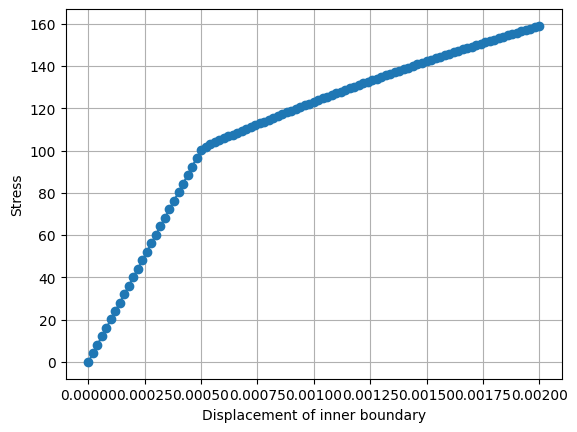

In [28]:
import matplotlib.pyplot as plt
plt.plot(results[:, 0]/geom["longside"], results[:, 1], "-o")
plt.xlabel("Displacement of inner boundary")
plt.ylabel(r"Stress")
plt.grid()
plt.show()